In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG16 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'virussign-vgg16features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vgg16features = np.load(filename)
else:
    print("Extracting features from VGG16 layers ...")
    vgg16features = base_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vgg16features)

Loading VGG16 extracted features from virussign-vgg16features.npy ...


In [8]:
vgg16features.shape

(10136, 7, 7, 512)

In [9]:
vgg16features = np.reshape(vgg16features,(vgg16features.shape[0],-1))

In [10]:
vgg16features.shape

(10136, 25088)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(vgg16features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 218.8min


[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............. C=0.01, gamma=1e-06, score=0.439349, total=138.5min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............. C=0.01, gamma=1e-06, score=0.429487, total=141.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............. C=0.01, gamma=1e-09, score=0.138067, total=143.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............. C=0.01, gamma=1e-08, score=0.138067, total=150.6min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.251479, total=151.2min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.248521, total=151.6min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=1e-06, score=0.432939, total=157.2min
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 259.5min


[CV] ............. C=0.01, gamma=1e-08, score=0.138067, total=169.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=1e-09, score=0.138067, total=168.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=1e-05, score=0.367357, total=176.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.249507, total=171.2min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=1e-08, score=0.138067, total=173.2min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=1e-08, score=0.138067, total=171.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.250986, total=174.6min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 284.4min


[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=1e-05, score=0.370809, total=176.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.207594, total=208.2min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.211538, total=210.2min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.208087, total=208.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.210552, total=206.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.207101, total=207.4min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.001, score=0.154339, total=208.3min
[CV] C

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 558.2min


[CV] .............. C=0.01, gamma=0.01, score=0.150888, total=211.4min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.1, score=0.153846, total=204.9min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] .............. C=0.01, gamma=0.01, score=0.155819, total=211.6min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] .............. C=0.01, gamma=0.01, score=0.148915, total=214.8min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.1, score=0.153353, total=214.4min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=0.1, score=0.150888, total=216.9min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=0.1, score=0.154832, total=213.5min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 813.0min


[CV] .............. C=0.1, gamma=1e-09, score=0.138067, total=161.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=1.0, score=0.138067, total=208.7min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=1e-09, score=0.138067, total=159.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=1e-09, score=0.138067, total=158.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=10.0, score=0.138067, total=208.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=1e-09, score=0.138067, total=161.6min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=10.0, score=0.138067, total=211.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 848.9min


[CV] ............. C=0.01, gamma=100.0, score=0.138067, total=213.7min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............. C=0.01, gamma=100.0, score=0.138067, total=208.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.138067, total=207.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.138067, total=210.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.138067, total=211.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.138067, total=208.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.138067, total=210.8min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 1022.6min


[CV] .............. C=0.1, gamma=1e-07, score=0.619822, total=118.6min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=1e-07, score=0.614892, total=116.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-08, score=0.248521, total=159.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-05, score=0.563609, total=150.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-08, score=0.250000, total=157.6min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-05, score=0.548323, total=150.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-05, score=0.556706, total=151.1min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 1244.1min


[CV] .............. C=0.1, gamma=0.001, score=0.259369, total=204.9min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] .............. C=0.1, gamma=0.001, score=0.258383, total=205.4min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] .............. C=0.1, gamma=0.001, score=0.253945, total=203.8min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.01, score=0.239645, total=206.6min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.01, score=0.233235, total=199.6min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ............... C=0.1, gamma=0.01, score=0.236193, total=204.9min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.1, score=0.236686, total=201.1min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 1362.5min


[CV] ................ C=0.1, gamma=1.0, score=0.229290, total=199.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.218442, total=199.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.221893, total=202.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.219921, total=200.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.218935, total=205.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.212032, total=207.8min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=100.0, score=0.220907, total=196.1min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 1578.5min


[CV] C=1.0, gamma=0.0001 .............................................
[CV] .............. C=1.0, gamma=1e-09, score=0.248521, total=151.2min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............. C=0.1, gamma=1000.0, score=0.220907, total=202.2min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .............. C=1.0, gamma=1e-09, score=0.249507, total=158.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............. C=0.1, gamma=1000.0, score=0.218935, total=197.2min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=1e-09, score=0.250000, total=160.2min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............. C=0.1, gamma=1000.0, score=0.217456, total=207.4min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=1e-08, score=0.625740, total=113.2min
[CV] C

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 1751.1min


[CV] .............. C=1.0, gamma=1e-05, score=0.730769, total=141.5min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=1e-05, score=0.708580, total=139.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=1e-05, score=0.718935, total=140.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............. C=1.0, gamma=0.0001, score=0.394477, total=188.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............. C=1.0, gamma=0.0001, score=0.383136, total=185.8min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............. C=1.0, gamma=0.0001, score=0.382643, total=180.7min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............. C=1.0, gamma=0.0001, score=0.374260, total=186.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 1913.8min


[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=0.1, score=0.299803, total=197.1min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.310651, total=196.2min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=0.1, score=0.307692, total=194.1min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.306213, total=196.0min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.306213, total=194.2min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.296351, total=196.9min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ............. C=10.0, gamma=1e-09, score=0.634122, total=111.1min
[CV] C

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 2160.1min


[CV] .............. C=1.0, gamma=100.0, score=0.283531, total=191.9min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.295365, total=192.8min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.293393, total=193.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=1.0, gamma=100.0, score=0.280079, total=204.3min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.919132, total=34.5min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.296844, total=201.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.280079, total=203.4min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 2348.2min


[CV] ............. C=10.0, gamma=1e-05, score=0.736193, total=139.2min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............. C=10.0, gamma=1e-05, score=0.724852, total=138.1min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............. C=10.0, gamma=1e-05, score=0.733235, total=139.7min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.389053, total=191.9min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.400394, total=193.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.388067, total=182.9min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.377712, total=191.7min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 2607.9min


[CV] ............. C=100.0, gamma=1e-09, score=0.855030, total=51.7min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] ............... C=10.0, gamma=0.1, score=0.309172, total=192.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.311637, total=192.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.837771, total=50.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.306706, total=192.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.306706, total=194.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.297337, total=191.5min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 2735.9min


[CV] ............. C=10.0, gamma=100.0, score=0.297337, total=189.7min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............ C=10.0, gamma=1000.0, score=0.295365, total=192.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.293886, total=189.0min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.280079, total=189.4min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.916174, total=36.1min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.296844, total=196.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.920118, total=34.4min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 3006.9min


[CV] ............ C=100.0, gamma=0.001, score=0.356509, total=195.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.001, score=0.350099, total=188.3min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=100.0, gamma=0.001, score=0.356016, total=185.3min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=100.0, gamma=0.001, score=0.341223, total=189.9min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=100.0, gamma=0.001, score=0.340237, total=187.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=0.01, score=0.330868, total=190.9min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=0.01, score=0.322485, total=186.6min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 3259.6min


[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.915680, total=33.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.918146, total=31.1min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.916174, total=32.2min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.310158, total=191.2min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.922091, total=34.1min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.295365, total=188.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............. C=100.0, gamma=10.0, score=0.305720, total=197.0min
[CV] C

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 3365.4min


[CV] ............ C=1000.0, gamma=1e-06, score=0.924063, total=52.2min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ........... C=1000.0, gamma=1e-05, score=0.731755, total=139.9min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ........... C=1000.0, gamma=1e-05, score=0.724852, total=138.9min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=1000.0, gamma=1e-05, score=0.736193, total=142.1min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=1000.0, gamma=1e-05, score=0.742604, total=145.2min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=1000.0, gamma=1e-05, score=0.733235, total=141.6min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .......... C=1000.0, gamma=0.0001, score=0.400394, total=183.4min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 3738.2min


[CV] ............. C=1000.0, gamma=1.0, score=0.306706, total=190.9min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=1.0, score=0.311637, total=194.4min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=1.0, score=0.306706, total=194.6min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=1.0, score=0.297337, total=189.0min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.914694, total=31.3min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.916174, total=32.2min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.918146, total=33.7min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 3878.2min


[CV] .......... C=1000.0, gamma=1000.0, score=0.280079, total=188.9min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-07, score=0.922091, total=34.9min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=1000.0, gamma=1000.0, score=0.283531, total=188.6min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.927022, total=50.6min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.921105, total=51.3min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.924063, total=51.7min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.918146, total=51.7min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 4191.2min


[CV] ............ C=10000.0, gamma=0.1, score=0.301282, total=194.5min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.917653, total=31.8min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.914694, total=32.5min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.925049, total=32.3min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.309172, total=191.6min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=1.0, score=0.306706, total=186.0min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=1.0, score=0.311637, total=193.7min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 4420.7min


[CV] ......... C=10000.0, gamma=1000.0, score=0.295365, total=191.8min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] ......... C=10000.0, gamma=1000.0, score=0.293886, total=192.0min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] ......... C=10000.0, gamma=1000.0, score=0.296844, total=191.3min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-07, score=0.922091, total=33.3min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=10000.0, gamma=1000.0, score=0.280079, total=194.8min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=10000.0, gamma=1000.0, score=0.283531, total=190.4min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-06, score=0.927022, total=51.8min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 4750.0min


[CV] ........... C=100000.0, gamma=0.1, score=0.311144, total=194.8min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.311144, total=195.6min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.914694, total=32.6min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.925049, total=32.8min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.917653, total=33.6min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ........... C=100000.0, gamma=1.0, score=0.306706, total=192.7min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.309172, total=194.3min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 4980.3min


[CV] ........ C=100000.0, gamma=1000.0, score=0.293886, total=196.2min
[CV] C=1000000.0, gamma=0.001 ........................................
[CV] ......... C=1000000.0, gamma=1e-07, score=0.922091, total=34.0min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=100000.0, gamma=1000.0, score=0.296844, total=194.1min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=100000.0, gamma=1000.0, score=0.283531, total=189.6min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=100000.0, gamma=1000.0, score=0.280079, total=192.5min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-06, score=0.927022, total=51.8min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-06, score=0.918146, total=52.3min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 5382.5min


[CV] ........ C=10000000.0, gamma=1e-09, score=0.914694, total=32.6min
[CV] C=10000000.0, gamma=1e-09 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.925049, total=32.6min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=1.0, score=0.306706, total=189.8min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=0.1, score=0.309172, total=197.2min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=1.0, score=0.306706, total=194.6min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=1.0, score=0.311637, total=195.2min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=1.0, score=0.297337, total=196.1min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 5586.0min


[CV] ........ C=10000000.0, gamma=1e-06, score=0.927022, total=51.6min
[CV] C=10000000.0, gamma=0.01 ........................................
[CV] ........ C=10000000.0, gamma=1e-06, score=0.918146, total=52.3min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=1e-06, score=0.921105, total=50.7min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=1e-06, score=0.924063, total=52.8min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=1e-06, score=0.924063, total=53.0min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=1e-05, score=0.724852, total=140.0min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=1e-05, score=0.731755, total=143.4min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed: 5983.1min


[CV] ....... C=100000000.0, gamma=1e-09, score=0.913215, total=33.0min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-09, score=0.918146, total=33.3min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.918146, total=33.5min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.914201, total=32.5min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.918146, total=32.1min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.924063, total=33.0min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.915187, total=32.2min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 6267.2min


[CV] ...... C=100000000.0, gamma=1e-05, score=0.733235, total=142.5min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.400394, total=188.2min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.389053, total=196.9min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ...... C=100000000.0, gamma=0.001, score=0.350099, total=188.9min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.388067, total=193.6min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.377712, total=193.7min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.386095, total=194.2min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 6637.2min


[CV] ....... C=100000000.0, gamma=10.0, score=0.301775, total=195.2min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ....... C=100000000.0, gamma=10.0, score=0.305720, total=198.1min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ....... C=100000000.0, gamma=10.0, score=0.310158, total=201.9min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=100000000.0, gamma=100.0, score=0.297337, total=195.2min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.916667, total=32.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.922584, total=32.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=100000000.0, gamma=100.0, score=0.297337, total=194.9min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 6966.7min


[CV] ...... C=1000000000.0, gamma=0.01, score=0.322485, total=200.2min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ...... C=1000000000.0, gamma=0.01, score=0.323964, total=194.6min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ...... C=1000000000.0, gamma=0.01, score=0.316568, total=192.3min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.311144, total=191.5min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.316568, total=192.9min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.311144, total=192.1min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.301282, total=191.1min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 7246.3min


[CV] .... C=1000000000.0, gamma=1000.0, score=0.280079, total=196.4min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=1000000000.0, gamma=1000.0, score=0.283531, total=196.3min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=1e-06, score=0.927022, total=51.2min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=1e-06, score=0.918146, total=52.5min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=10000000000.0, gamma=1e-06, score=0.924063, total=51.6min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=10000000000.0, gamma=1e-06, score=0.924063, total=52.0min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=10000000000.0, gamma=1e-06, score=0.921105, total=52.6min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed: 7753.3min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [ ]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 9.9999999999999995e-07} - score: 0.9229


In [ ]:
top_model.cv_results_

{'mean_fit_time': array([  8281.28865142,   8635.95806413,   8237.06983991,   7242.31729279,
          9772.0839366 ,  11073.55384936,  11301.59771633,  11219.01433969,
         11410.28273726,  11271.74712439,  11145.19294748,  11237.12715158,
         11263.16854906,   8192.69066463,   8114.38393178,   5788.63524575,
          3250.80596509,   8043.83939543,  10522.88354526,  10851.52971945,
         10909.84317241,  10949.86921582,  10876.56086159,  10882.32521944,
         10969.72674322,  10973.16419101,   8116.99809484,   5700.46915202,
          2313.33310328,   2165.21435723,   7545.81386867,  10009.01713376,
         10355.95846486,  10443.82167158,  10487.58602347,  10509.07814083,
         10593.35121269,  10532.94382644,  10666.46280761,   5508.38633385,
          2188.32110977,   1435.07765183,   2395.03887758,   7549.33087587,
         10260.52281203,  10310.14725485,  10212.61821275,  10383.44967227,
         10474.47394385,  10428.76860037,  10086.81122684,  10326.03253

In [ ]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-09},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.25010, std: 0.00105, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.43245, std: 0.00557, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.36203, std: 0.00699, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.20897, std: 0.00175, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.15286, std: 0.00235, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.15276, std: 0.00250, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.15237, std: 0.00216, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 100.0},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1000.0},
 mean: 0.13807, std: 0.00000, params: {'C': 0.100

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

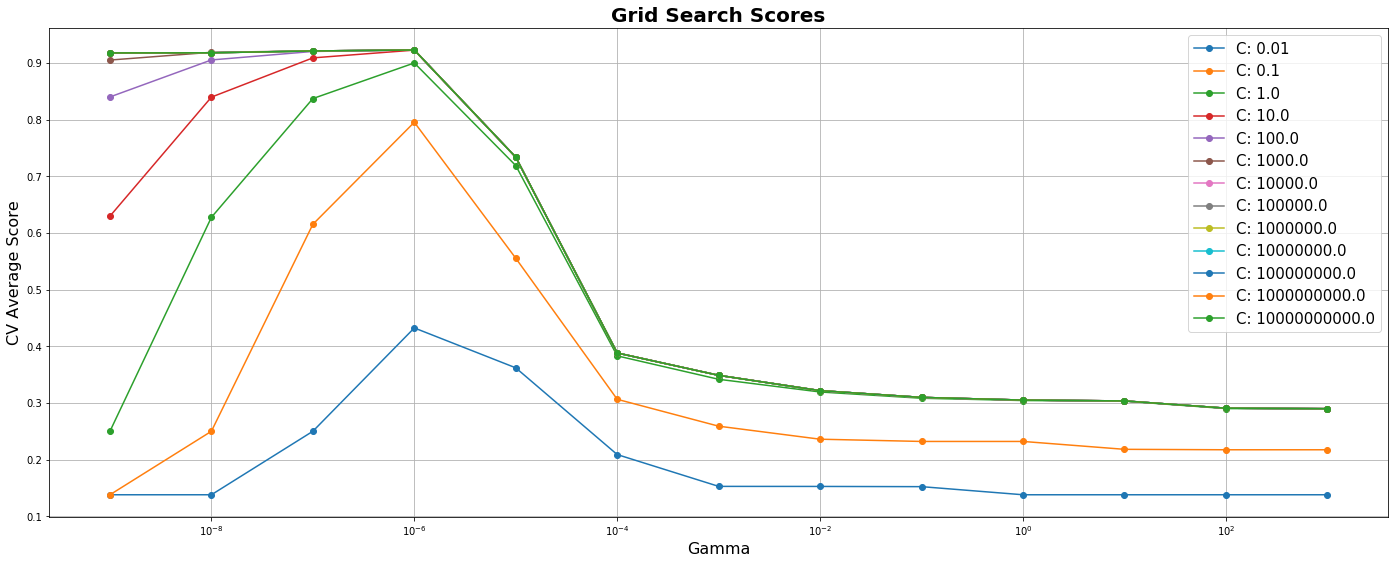

In [ ]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


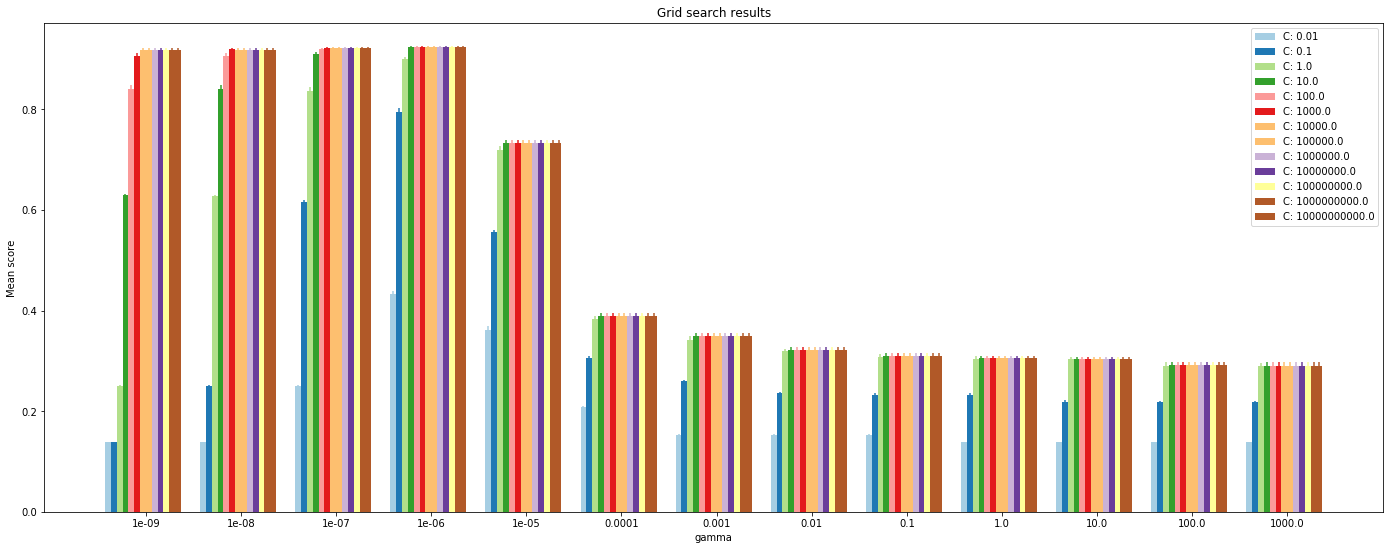

In [ ]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


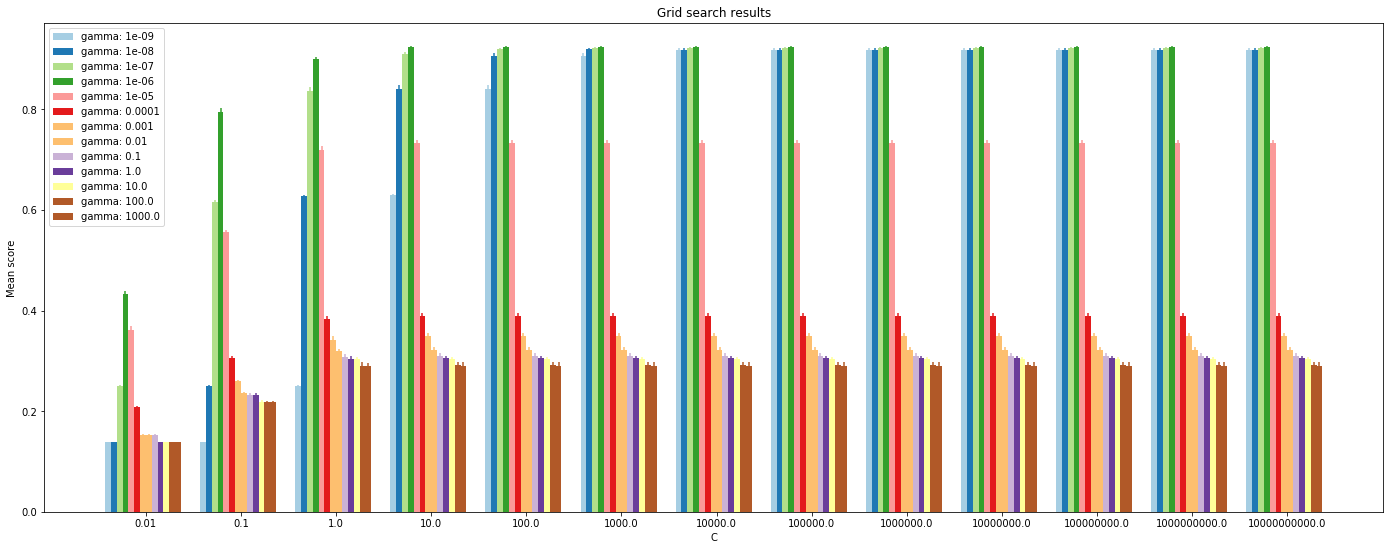

In [ ]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [11]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=100.0,gamma=1e-06)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, vgg16features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

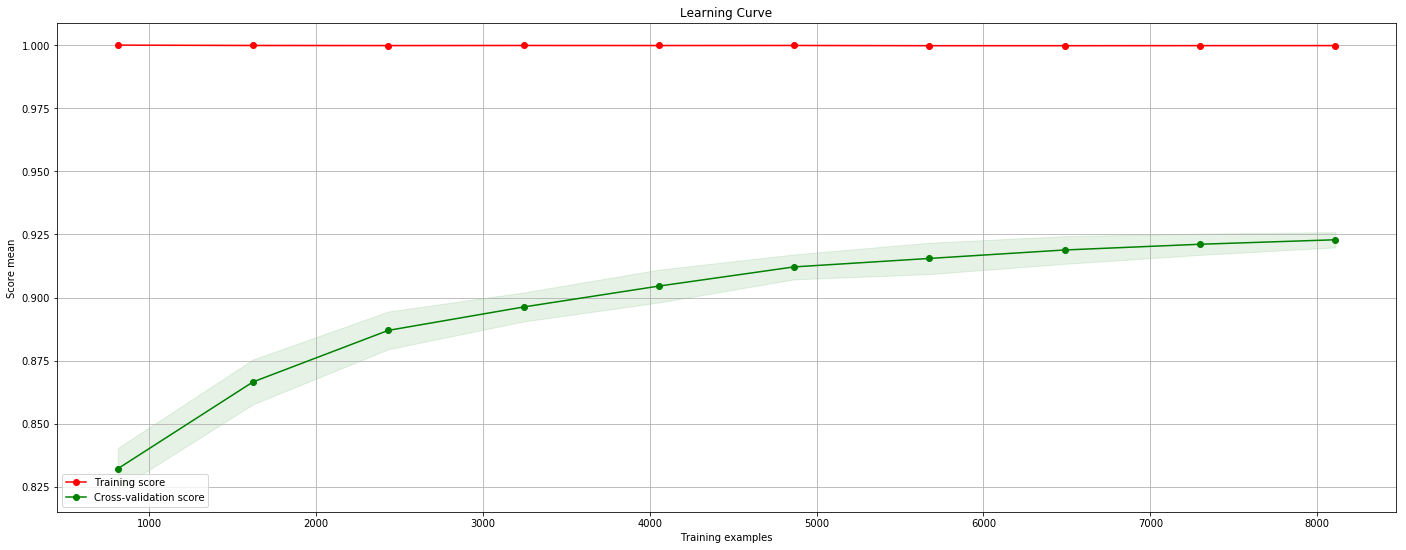

In [12]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()